In [1]:
import sys
sys.path.append("..")
import datetime

from src.helper import make_ts

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## 3.1 Simple forecasting methods

### Average Method:

The forecasts of all future values are equal to the average of the historical data:


$\hat{y}_{T+h|T}=\bar{y}=(y_{1}+..+y_{T})/T$

In [2]:
ts_df = make_ts('2000',20)

In [3]:
ts_df.head()

,Observation
Date,
2000-01-01,44.203435
2001-01-01,70.439696
2002-01-01,81.952803
2003-01-01,48.890277
2004-01-01,63.527254


In [4]:
def average_forecast(y, h):
    """
    y = time series index of pandas data frame
    h = forecast horizon
    
    TODO: Move to helper.py. 
    """
    ts = pd.DataFrame(pd.date_range(
                                        str(ts_df.index[-1] + datetime.timedelta(days=365)), 
                                        periods = h, 
                                        freq=pd.infer_freq(y.index)
                                        ), 
                      columns = ['Date']
                     )
    ts['Forecast_AVG'] = y['Observation'].mean()
    ts.set_index('Date', inplace = True)
    return ts

In [5]:
forecast_avg = average_forecast(ts_df, 10)

## Naïve method

The forecasts of all future values are equal to the average of the historical data:


$\hat{y}_{T+h|T}=y_{T}$

In [6]:
def naive_forecast(y, h):
    """
    y = time series index of pandas data frame
    h = forecast horizon
    
    TODO: Move to helper.py. 
    """
    ts = pd.DataFrame(pd.date_range(
                                        str(ts_df.index[-1] + datetime.timedelta(days=365)), 
                                        periods = h, 
                                        freq=pd.infer_freq(y.index)
                                        ), 
                      columns = ['Date']
                     )
    ts['Forecast_Naive'] = y['Observation'][-1]
    ts.set_index('Date', inplace = True)
    return ts

In [7]:
forecast_naive = naive_forecast(ts_df, 10)

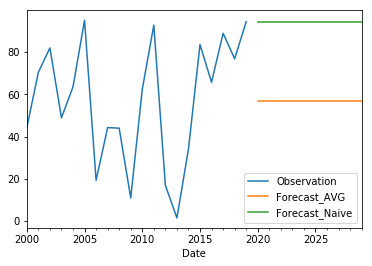

In [8]:
fig, ax = plt.subplots()
ts_df.plot(ax = ax)
forecast_avg.plot(ax = ax)
forecast_naive.plot(ax=ax)

In [9]:
seasonal = make_ts("2000", 12*20, 'M')

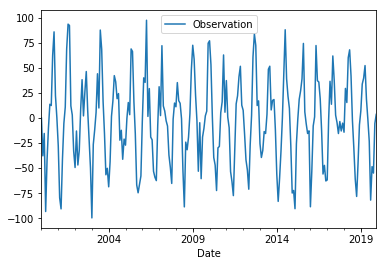

In [10]:
seasonal.plot()